In [1]:
# install for AWS
!pip install torch
!pip install pandas
!pip install scikit-image
!pip install scikit-learn
!pip install matplotlib
!pip install torchvision
!pip install s3fs
# !pip install fiftyone

In [2]:
import os
import torch
import tarfile
import shutil
import torchvision
import random
import warnings
import boto3
import s3fs
import io
import time
import botocore.exceptions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils, models, datasets
from io import BytesIO
from torch import nn, optim

warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


# import fiftyone as fo
# import fiftyone.brain as fob
# import fiftyone.zoo as foz
# from fiftyone import ViewField as F

# Define Hyperparams

In [3]:
batch_size = 32
learning_rate = 0.001
num_classes = 52
num_epochs = 2
fine_tune_epochs = 3
disparity_weight = 0.1
alpha = 0.5

# Load, Transform, and Split Data

In [4]:
# Initialize S3 client
s3_client = boto3.client('s3', region_name='us-west-2')

In [5]:
# Define the S3 bucket name and prefixes
bucket_name = 'w210facetdata'
annotations_prefix = 'annotations/'
images_prefix = 'images/'

In [6]:
# Load CSV annotations from S3
annotations_s3_path = f's3://{bucket_name}/{annotations_prefix}annotations.csv'
df = pd.read_csv(annotations_s3_path)

In [7]:
# Extracting unique class labels from the 'class1' column
classes = df['class1'].unique()

# Creating a mapping from index to class label
idx_to_class = {i: j for i, j in enumerate(classes)}

# Creating a reverse mapping from class label to index
class_to_idx = {value: key for key, value in idx_to_class.items()}

# Creating a mapping from index to annotation column name starting from the 7th column
idx_to_annot = {i: j for i, j in enumerate(df.columns[6:])}


In [8]:
# # check count of jpg files
# def count_jpg_files(bucket_name, prefix=''):
#     """
#     Count the number of .jpg files in an S3 bucket under a given prefix.
    
#     Parameters:
#     - bucket_name (str): Name of the S3 bucket.
#     - prefix (str): Prefix path to filter results. Default is empty.
    
#     Returns:
#     - count (int): Count of .jpg files.
#     """
#     count = 0
#     paginator = s3_client.get_paginator('list_objects_v2')
    
#     for page in paginator.paginate(Bucket=bucket_name, Prefix=prefix):
#         for obj in page.get('Contents', []):
#             if obj['Key'].endswith('.jpg'):
#                 count += 1

#     return count

# # Count .jpg files in the 'w210facetdata' bucket under the 'images/' prefix
# jpg_count = count_jpg_files(bucket_name, images_prefix)
# print(f"Number of .jpg files in the '{bucket_name}/{images_prefix}' path: {jpg_count}")


In [9]:
# df.iloc[0][6:]

In [10]:
# idx_to_class

In [11]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [12]:
# Split data into train, validation, and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)


In [13]:
# toggle on/off subsetting
# Define the number of samples you want in your subset
subset_size = 10  # Adjust the size as needed

# Create a smaller subset of your dataset
train_data = train_data[:subset_size]
test_data = test_data[:subset_size]
val_data = val_data[:subset_size]

In [14]:
# Define additional metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Lists to store metric values during training
train_losses_student, val_losses_student, train_losses_teacher, val_losses_teacher = [], [], [], []
train_accuracies_student, val_accuracies_student, train_accuracies_teacher, val_accuracies_teacher = [], [], [], []


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
class CustomDataset(Dataset):
    def __init__(self, split_data, image_dir, transform=None):
        self.data = split_data
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 2]
        image_key = f'{images_prefix}{img_name}'  # Construct S3 object key
        # Load image from S3
        img_object = s3_client.get_object(Bucket=bucket_name, Key=image_key)
        img_data = img_object['Body'].read()
        # Open the image directly from the byte stream using PIL
        image = Image.open(BytesIO(img_data))
        annotations = self.data.iloc[idx, 6:].values.astype(np.float16).reshape(-1, 1)
        label = class_to_idx[self.data.iloc[idx, 3]]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label), torch.from_numpy(annotations)

# Create custom datasets and data loaders
image_dir = 'FACET'  # Local directory if you want to save images locally
train_dataset = CustomDataset(split_data=train_data, image_dir=image_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(split_data=test_data, image_dir=image_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = CustomDataset(split_data=val_data, image_dir=image_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [17]:
# fig = plt.figure()

# for i, sample in enumerate(train_dataset):
#     ax = plt.subplot(1, 4, i + 1)
#     plt.imshow(np.transpose(sample[0], [1,2,0]))
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
#     ax.axis('off')
#     plt.show()
#     if i == 3:
#         break


# Model

In [18]:
# device = torch.device('mps')

# Define your smaller ResNet student model
# Deeper neural network class to be used as teacher:
class DeepNN(nn.Module):
    def __init__(self, num_classes=52):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(131072, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=52):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(65536, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Define loss functions
criterion_teacher = nn.CrossEntropyLoss()  # Loss for teacher model
criterion_student = nn.KLDivLoss()  # Knowledge distillation loss

# Instantiate the teacher and student models
teacher_model = torchvision.models.resnet50(pretrained=True)
num_ftrs = teacher_model.fc.in_features
teacher_model.fc = nn.Linear(num_ftrs, num_classes)
teacher_model = teacher_model.to(device)

student_model = LightNN(num_classes=num_classes).to(device)

# Define optimizer for the student model
optimizer_student = optim.Adam(student_model.parameters(), lr=learning_rate)
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=learning_rate)


# Train


In [19]:
# Define attributes and concepts in your dataset
attributes = df.columns[6:].tolist()  # All attributes
concepts = list(idx_to_class.values())  # All concepts

# Create a dictionary to map attribute names to column indices
attr_idx = {attr: idx for idx, attr in enumerate(attributes)}

# Initialize dictionaries to store recall values for teacher and student models
teacher_recall_values = {attr: {concept: [] for concept in concepts} for attr in attributes}
student_recall_values = {attr: {concept: [] for concept in concepts} for attr in attributes}


In [20]:
# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

# Training loop
for epoch in range(num_epochs):
    student_model.train()
    teacher_model.train()
    for images, labels, annotations in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_student.zero_grad()
        optimizer_teacher.zero_grad()

        # Forward pass
        teacher_outputs = teacher_model(images).to(device)
        student_outputs = student_model(images).to(device)

        # Calculate additional metrics including recall
        recall_student = recall_score(labels.cpu().numpy(), torch.argmax(student_outputs, dim=1).cpu().numpy(), average='weighted')
        recall_teacher = recall_score(labels.cpu().numpy(), torch.argmax(teacher_outputs, dim=1).cpu().numpy(), average='weighted')

        # Update recall values
        for attr in attributes:
            for concept in concepts:
                # Check if the sample belongs to the specified attribute and concept
                attr_indices = np.where(annotations[:, attr_idx[attr]].cpu().numpy() == 1)[0]  # Get indices where attribute is 1
                concept_indices = np.where(labels.cpu().numpy() == class_to_idx[concept])[0]  # Get indices where concept matches
                common_indices = np.intersect1d(attr_indices, concept_indices)  # Common indices
                if common_indices.size > 0:
                    teacher_recall_values[attr][concept].append(recall_teacher)
                    student_recall_values[attr][concept].append(recall_student)

        # Calculate the Knowledge Distillation loss and Cross Entropy loss
        kd_loss = criterion_student(
            F.log_softmax(student_outputs / 5, dim=1),  # Apply temperature scaling
            F.softmax(teacher_outputs / 5, dim=1)  # Apply temperature scaling
        )
        ce_loss = criterion_teacher(student_outputs, labels)
    
    # Calculate the disparity for each attribute and concept
    for attr in attributes:
        for concept in concepts:
            # Calculate the disparity (difference in recall)
            teacher_recall = np.mean(teacher_recall_values[attr][concept])
            student_recall = np.mean(student_recall_values[attr][concept])
            disparity = teacher_recall - student_recall
    
            # Clone tensors before performing inplace operations
            kd_loss = kd_loss.clone()
            ce_loss = ce_loss.clone()
            disparity_tensor = torch.tensor(disparity, dtype=torch.float32).to(device)  # Convert disparity to a PyTorch tensor
            disparity_loss = disparity_weight * disparity_tensor.clone()
            total_loss = alpha * kd_loss + (1 - alpha) * ce_loss + disparity_loss
    
    # Perform the backward pass with retain_graph=True
    total_loss.backward(retain_graph=True)
    
    # Optimize the models
    optimizer_student.step()
    optimizer_teacher.step()

# Disable anomaly detection when done
torch.autograd.set_detect_anomaly(False)

# Evaluate

In [26]:
def calculate_disparity(teacher_recall_values, student_recall_values):
    disparity_values = {}
    for attr in attributes:  # Ensure 'attributes' is defined and correctly formatted
        disparity_values[attr] = {}
        for concept in concepts:  # Ensure 'concepts' is defined and correctly formatted
            teacher_values = teacher_recall_values.get(attr, {}).get(concept, [])
            student_values = student_recall_values.get(attr, {}).get(concept, [])
            if teacher_values and student_values:  # Check non-empty lists
                disparity_values[attr][concept] = np.mean(
                    [teacher_val - student_val for teacher_val, student_val in zip(teacher_values, student_values)]
                )
            else:
                print(f"Missing values for attr: {attr}, concept: {concept}")  # Debugging print statement
    return disparity_values

In [27]:
# Validation
student_model.eval()
teacher_model.eval()
val_loss_student = 0.0
val_predictions_student = []
val_targets_student = []

val_loss_teacher = 0.0
val_predictions_teacher = []
val_targets_teacher = []

start_time = time.time()

with torch.no_grad():
    for images, labels, annotations in val_loader:
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        student_outputs = student_model(images)
        teacher_outputs = teacher_model(images)

        # Calculate cross-entropy loss for validation
        student_loss = criterion_teacher(student_outputs, labels)
        teacher_loss = criterion_teacher(teacher_outputs, labels)

        val_loss_student += student_loss.item()
        val_loss_teacher += teacher_loss.item()

        # Store predictions and ground truth labels for metrics
        val_predictions_student.extend(torch.argmax(student_outputs, dim=1).cpu().numpy())
        val_predictions_teacher.extend(torch.argmax(teacher_outputs, dim=1).cpu().numpy())

        val_targets_student.extend(labels.cpu().numpy())
        val_targets_teacher.extend(labels.cpu().numpy())

end_time = time.time()  # End time measurement
inference_time_student = (end_time - start_time) / len(val_loader)
inference_time_teacher = (end_time - start_time) / len(val_loader)

val_disparity_values = calculate_disparity(teacher_recall_values, student_recall_values)

# Calculate the average disparity
avg_disparity = np.mean(
    [value for attr_dict in val_disparity_values.values()
     for concept_dict in attr_dict.values()
     for value in (concept_dict.values() if isinstance(concept_dict, dict) else [concept_dict])])



# Calculate validation accuracy and recall
val_accuracy_student = accuracy_score(val_targets_student, val_predictions_student)
val_accuracy_teacher = accuracy_score(val_targets_teacher, val_predictions_teacher)
val_recall_student = recall_score(val_targets_student, val_predictions_student, average='weighted')
val_recall_teacher = recall_score(val_targets_teacher, val_predictions_teacher, average='weighted')
val_precision_student = precision_score(val_targets_student, val_predictions_student, average='weighted')
val_precision_teacher = precision_score(val_targets_teacher, val_predictions_teacher, average='weighted')
val_f1_student = f1_score(val_targets_student, val_predictions_student, average='weighted')
val_f1_teacher = f1_score(val_targets_teacher, val_predictions_teacher, average='weighted')

# Get model size (number of parameters)
model_size_student = sum(p.numel() for p in student_model.parameters())
model_size_teacher = sum(p.numel() for p in teacher_model.parameters())

val_metrics_teacher = calculate_metrics(val_targets_teacher, val_predictions_teacher)
val_metrics_student = calculate_metrics(val_targets_student, val_predictions_student)
  sv
# Gather metrics in dictionaries for easier plotting
teacher_metrics = {
    'Accuracy': val_metrics_teacher[0],
    'Precision': val_metrics_teacher[1],
    'Recall': val_metrics_teacher[2],
    'F1 Score': val_metrics_teacher[3],
    'Disparity': avg_disparity,  # Corrected here
    'Model Size': model_size_teacher,
    'Inference Time': inference_time_teacher
}

student_metrics = {
    'Accuracy': val_metrics_student[0],
    'Precision': val_metrics_student[1],
    'Recall': val_metrics_student[2],
    'F1 Score': val_metrics_student[3],
    'Disparity': avg_disparity,  # Corrected here
    'Model Size': model_size_student,
    'Inference Time': inference_time_student
}

# Define labels for plotting
size_labels = ['Model Size']
time_labels = ['Inference Time']
other_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Disparity']  # Define labels for other metrics

# Extract values for each type of metric
size_teacher_values = [teacher_metrics['Model Size']]
size_student_values = [student_metrics['Model Size']]

time_teacher_values = [teacher_metrics['Inference Time']]
time_student_values = [student_metrics['Inference Time']]

other_teacher_values = [teacher_metrics[key] for key in other_labels]
other_student_values = [student_metrics[key] for key in other_labels]

# Print validation results for this epoch
print(f'Epoch [{epoch+1}/{num_epochs}]'
      f' Teacher Loss: {val_loss_teacher / len(val_loader):.4f}'
      f' Teacher Accuracy: {val_accuracy_teacher:.4f}'
      f' Teacher Recall: {val_recall_teacher:.4f}'
      f' Student Loss: {val_loss_student / len(val_loader):.4f}'
      f' Student Accuracy: {val_accuracy_student:.4f}'
      f' Student Recall: {val_recall_student:.4f}')

# Print disparity for validation
for attr in attributes:
    for concept in concepts:
        # Handle potential missing values with a default of NaN or another value of your choice
        print(f'Validation Disparity for {attr} and {concept}: {val_disparity_values.get(attr, {}).get(concept, np.nan):.4f}')


Missing values for attr: gender_presentation_masc, concept: gymnast
Missing values for attr: gender_presentation_masc, concept: backpacker
Missing values for attr: gender_presentation_masc, concept: lawman
Missing values for attr: gender_presentation_masc, concept: laborer
Missing values for attr: gender_presentation_masc, concept: patient
Missing values for attr: gender_presentation_masc, concept: basketball_player
Missing values for attr: gender_presentation_masc, concept: nurse
Missing values for attr: gender_presentation_masc, concept: singer
Missing values for attr: gender_presentation_masc, concept: astronaut
Missing values for attr: gender_presentation_masc, concept: fireman
Missing values for attr: gender_presentation_masc, concept: speaker
Missing values for attr: gender_presentation_masc, concept: guitarist
Missing values for attr: gender_presentation_masc, concept: repairman
Missing values for attr: gender_presentation_masc, concept: craftsman
Missing values for attr: gender

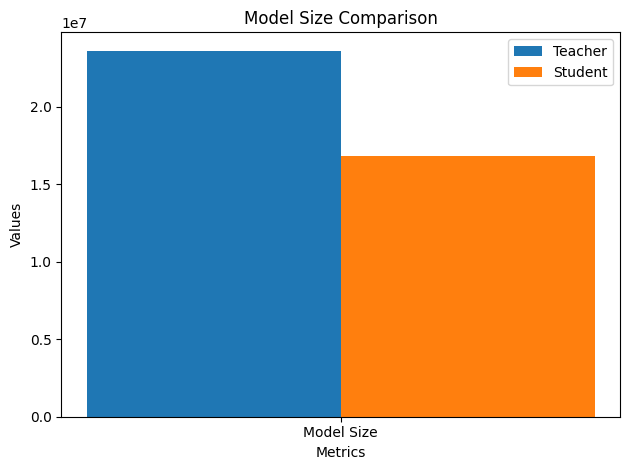

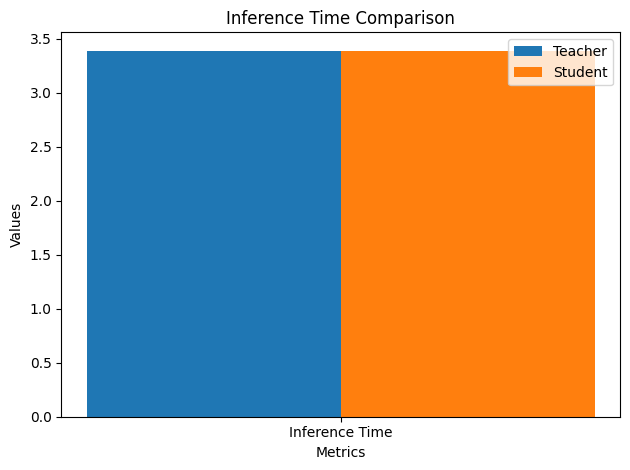

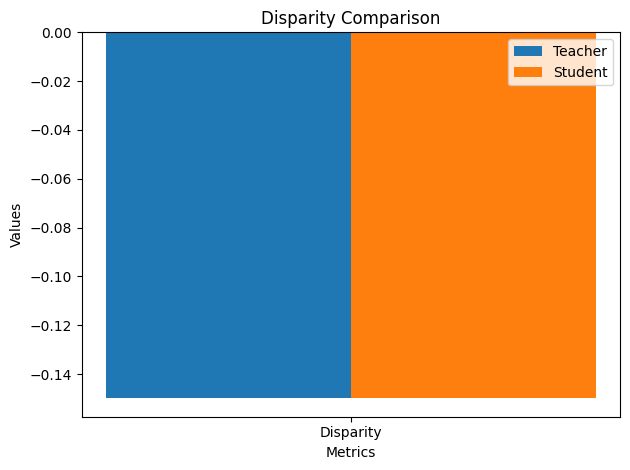

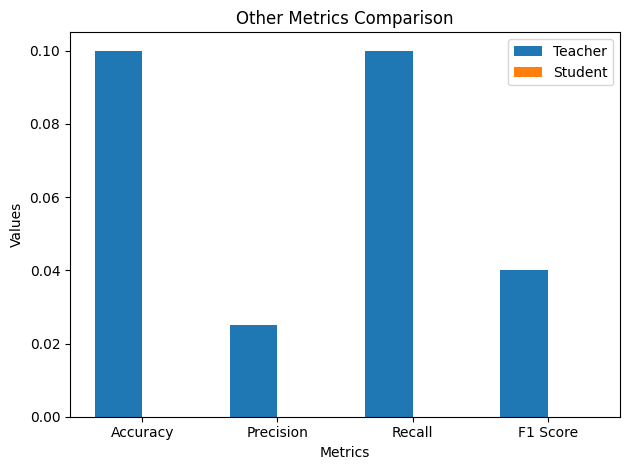

In [30]:
def create_plot(labels, teacher_values, student_values, title):
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

# Function to create a bar plot specifically for disparity
def plot_disparity(title):
    labels = ['Disparity']
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, [teacher_metrics['Disparity']], width, label='Teacher')
    rects2 = ax.bar(x + width/2, [student_metrics['Disparity']], width, label='Student')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

# ... rest of your code ...

# Create plots
create_plot(size_labels, size_teacher_values, size_student_values, 'Model Size Comparison')
create_plot(time_labels, time_teacher_values, time_student_values, 'Inference Time Comparison')
plot_disparity('Disparity Comparison')  # New function call for disparity
create_plot(other_labels[:-1], other_teacher_values[:-1], other_student_values[:-1], 'Other Metrics Comparison')  

In [ ]:
torch.save(student_model.state_dict(), 'student_model2.pth')
torch.save(teacher_model.state_dict(), 'teacher_model2.pth')

In [ ]:
accuracy_score(val_targets_student, val_predictions_student)

In [ ]:
accuracy_score(val_targets_teacher, val_predictions_teacher)

In [ ]:
val_loss_student / len(val_loader)

In [ ]:
val_loss_teacher / len(val_loader)